In [1]:
#%%capture
!pip install yfinance==0.2.58
#!pip install yfinance
#!pip install twelvedata
import numpy as np
import pandas as pd
import yfinance as yf
!pip show yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.7/113.7 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.63
    Uninstalling yfinance-0.2.63:
      Successfully uninstalled yfinance-0.2.63
Name: yfinance
Version: 0.2.58
Summary: Download market data from Yahoo! Finance API
Home-page: https://github.com/ranaroussi/yfinance
Author: Ran Aroussi
Author-email: ran@aroussi.com
License: Apache
Location: /usr/local/lib/python3.11/dist-packages
Requires: beautifulsoup4, curl_cffi, frozendict, multitasking, numpy, pandas, peewee, platformdirs, pytz, requests
Required-by: 


In [71]:
ticker = "1120.SR"
"""
ticker = "1120:Tadawul"
from twelvedata import TDClient

# Initialize TDClient with your API key
td = TDClient(apikey="2ced3e308ffe4a2ea90b4e4ca728fa9d")

ts = td.time_series(
    symbol=ticker,
    interval="1day",
    outputsize=100  # Number of data points to retrieve
)

# Convert to pandas DataFrame for easier manipulation
df = ts.as_pandas()
"""
data = yf.download(ticker, start="2022-01-01", end="2025-06-23")
data

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,1120.SR,1120.SR,1120.SR,1120.SR,1120.SR
Date,,,,,
2022-01-02,82.998947,83.230788,81.955664,82.419346,4634990
2022-01-03,82.767105,83.926308,81.839743,82.651185,6670904
2022-01-04,82.767105,83.346707,82.071583,83.346707,4651737
2022-01-05,82.651184,83.114865,82.303423,82.651184,3808107
2022-01-06,82.535263,83.230785,82.187502,82.419343,4369828
...,...,...,...,...,...
2025-06-16,92.599998,93.400002,91.199997,91.199997,3653317
2025-06-17,91.699997,93.099998,91.500000,92.599998,3959192


In [72]:
# Find the lowest price for the stock over the last week
data["prv_low_1"] = data["Low"].shift(1)
data["prv_low_2"] = data["Low"].shift(2)
data["prv_low_3"] = data["Low"].shift(3)
data["prv_low_4"] = data["Low"].shift(4)
data["prv_low_5"] = data["Low"].shift(5)
data["Low_Last_5d"] = data[["prv_low_1", "prv_low_2","prv_low_3","prv_low_4","prv_low_5"]].values.min(1)
data = data.drop(["prv_low_1", "prv_low_2", "prv_low_3", "prv_low_4", "prv_low_5"], axis=1)

# Find the highest price for the stock over the last week
data['prv_high_1'] = data["High"].shift(1)
data['prv_high_2'] = data["High"].shift(2)
data['prv_high_3'] = data["High"].shift(3)
data['prv_high_4'] = data["High"].shift(4)
data['prv_high_5'] = data["High"].shift(5)
data["High_Last_5d"] = data[["prv_high_1", "prv_high_2","prv_high_3","prv_high_4","prv_high_5"]].values.max(1)
data = data.drop(["prv_high_1", "prv_high_2", "prv_high_3", "prv_high_4", "prv_high_5"], axis=1)
data.tail(2)

Price,Close,High,Low,Open,Volume,Low_Last_5d,High_Last_5d
Ticker,1120.SR,1120.SR,1120.SR,1120.SR,1120.SR,,
Date,,,,,,,
2025-06-19,91.199997,91.599998,90.5,91.099998,3742444,88.099998,93.800003
2025-06-22,90.099998,92.199997,90.0,91.199997,2380902,88.099998,93.400002


In [73]:
# Create boolean variable marking whether stock dropped at least six percent in the last week (five days)
data["six_percent_of_close_price"] = .94*data["Close"]
data["Close"] = 1*data["Close"]
data["six_percent_of_close_price_within_last_five_days"] = np.where((data['Low_Last_5d'] <= data['six_percent_of_close_price']) & (data['six_percent_of_close_price'] <= data['High_Last_5d']), True, False)

In [74]:
# Create boolean variable marking whether current close price is greater than yesterdays close price
data["Last_Close"] = data["Close"].shift(1)
data["close_diff"] = data["Close"].values.reshape(data.shape[0]) - data["Last_Close"].values.reshape(data.shape[0])
data["up_from_yesterday"] = np.where((data["close_diff"] > 0), True, False)
data.tail(5)

Price,Close,High,Low,Open,Volume,Low_Last_5d,High_Last_5d,six_percent_of_close_price,six_percent_of_close_price_within_last_five_days,Last_Close,close_diff,up_from_yesterday
Ticker,1120.SR,1120.SR,1120.SR,1120.SR,1120.SR,,,,,,,
Date,,,,,,,,,,,,
2025-06-16,92.599998,93.400002,91.199997,91.199997,3653317,88.099998,95.199997,87.043999,False,91.199997,1.400002,True
2025-06-17,91.699997,93.099998,91.500000,92.599998,3959192,88.099998,95.199997,86.197997,False,92.599998,-0.900002,False
2025-06-18,91.500000,91.699997,90.500000,91.000000,1696730,88.099998,95.199997,86.010000,False,91.699997,-0.199997,False
2025-06-19,91.199997,91.599998,90.500000,91.099998,3742444,88.099998,93.800003,85.727997,False,91.500000,-0.300003,False
2025-06-22,90.099998,92.199997,90.000000,91.199997,2380902,88.099998,93.400002,84.693999,False,91.199997,-1.099998,False


In [75]:
# Buy stock if price dropped at least seven percent in last week and current close price is greater than yesterdays close price
data["shortsell"] = data["six_percent_of_close_price_within_last_five_days"] & data["up_from_yesterday"]
data["shortsellcumsum"] = data["shortsell"].cumsum().astype('int64')
data = data.drop(["Last_Close","close_diff","six_percent_of_close_price","up_from_yesterday","six_percent_of_close_price_within_last_five_days","Low_Last_5d","High_Last_5d"], axis=1)

# Add numerical columns of stocks current close price increased and decrease by one percent for final analysis
data["Close_up1%"] = 1.01*data["Close"]
data["Close_down1%"] = .99*data["Close"]
data.tail(10)

Price,Close,High,Low,Open,Volume,shortsell,shortsellcumsum,Close_up1%,Close_down1%
Ticker,1120.SR,1120.SR,1120.SR,1120.SR,1120.SR,,,,
Date,,,,,,,,,
2025-06-03,90.000000,91.099998,89.800003,91.000000,2996259,False,48,90.900000,89.100000
2025-06-04,93.300003,93.400002,90.099998,90.300003,6143607,False,48,94.233003,92.367003
2025-06-11,93.699997,95.199997,93.199997,94.000000,4913697,True,49,94.636997,92.762997
2025-06-12,92.599998,93.800003,92.000000,93.699997,3442999,False,49,93.525998,91.673998
2025-06-15,91.199997,92.000000,88.099998,88.099998,2784804,False,49,92.111997,90.287997
2025-06-16,92.599998,93.400002,91.199997,91.199997,3653317,False,49,93.525998,91.673998
2025-06-17,91.699997,93.099998,91.500000,92.599998,3959192,False,49,92.616997,90.782997
2025-06-18,91.500000,91.699997,90.500000,91.000000,1696730,False,49,92.415000,90.585000


In [76]:
# view dates where we buy the stock + the two days after
#buyclause = data['buy']==True
#view = data[buyclause.shift(2)|buyclause.shift()|buyclause]
#view

In [77]:
data.loc[(data.shortsell == False), 'Close_up1%'] = np.nan
data.loc[(data.shortsell == False), 'Close_down1%'] = np.nan
data.tail(10)

Price,Close,High,Low,Open,Volume,shortsell,shortsellcumsum,Close_up1%,Close_down1%
Ticker,1120.SR,1120.SR,1120.SR,1120.SR,1120.SR,,,,
Date,,,,,,,,,
2025-06-03,90.000000,91.099998,89.800003,91.000000,2996259,False,48,NaN,NaN
2025-06-04,93.300003,93.400002,90.099998,90.300003,6143607,False,48,NaN,NaN
2025-06-11,93.699997,95.199997,93.199997,94.000000,4913697,True,49,94.636997,92.762997
2025-06-12,92.599998,93.800003,92.000000,93.699997,3442999,False,49,NaN,NaN
2025-06-15,91.199997,92.000000,88.099998,88.099998,2784804,False,49,NaN,NaN
2025-06-16,92.599998,93.400002,91.199997,91.199997,3653317,False,49,NaN,NaN
2025-06-17,91.699997,93.099998,91.500000,92.599998,3959192,False,49,NaN,NaN
2025-06-18,91.500000,91.699997,90.500000,91.000000,1696730,False,49,NaN,NaN


In [78]:
data["Close_up1%"] = data["Close_up1%"].ffill()
data["Close_down1%"] = data["Close_down1%"].ffill()
data.tail(10)

Price,Close,High,Low,Open,Volume,shortsell,shortsellcumsum,Close_up1%,Close_down1%
Ticker,1120.SR,1120.SR,1120.SR,1120.SR,1120.SR,,,,
Date,,,,,,,,,
2025-06-03,90.000000,91.099998,89.800003,91.000000,2996259,False,48,98.070998,96.128998
2025-06-04,93.300003,93.400002,90.099998,90.300003,6143607,False,48,98.070998,96.128998
2025-06-11,93.699997,95.199997,93.199997,94.000000,4913697,True,49,94.636997,92.762997
2025-06-12,92.599998,93.800003,92.000000,93.699997,3442999,False,49,94.636997,92.762997
2025-06-15,91.199997,92.000000,88.099998,88.099998,2784804,False,49,94.636997,92.762997
2025-06-16,92.599998,93.400002,91.199997,91.199997,3653317,False,49,94.636997,92.762997
2025-06-17,91.699997,93.099998,91.500000,92.599998,3959192,False,49,94.636997,92.762997
2025-06-18,91.500000,91.699997,90.500000,91.000000,1696730,False,49,94.636997,92.762997


In [79]:
data["buyup"] = np.where((data["Close"].values.reshape(data.shape[0])-data["Close_up1%"].values.reshape(data.shape[0]) > 0),True,False)
data["buydown"] = np.where((data["Close_down1%"].values.reshape(data.shape[0])-data["Close"].values.reshape(data.shape[0]) > 0),True,False)
data["buy"] = data["buydown"]|data["buyup"]
data["buycumsum"] = data["buy"].cumsum().astype('int64')
#data.to_csv('out.csv', index=False)
#data = pd.read_csv('out.csv')
#data.tail(10)

In [80]:
#from collections import defaultdict
#dates = ["2024-01-29","2024-06-10","2024-08-27","2024-10-09","2024-10-14","2024-11-12","2025-01-05","2025-02-06","2025-04-16","2025-06-12"]
#values = []

In [81]:
data.loc[data.shortsellcumsum==x].columns

MultiIndex([(          'Close', '1120.SR'),
            (           'High', '1120.SR'),
            (            'Low', '1120.SR'),
            (           'Open', '1120.SR'),
            (         'Volume', '1120.SR'),
            (      'shortsell',        ''),
            ('shortsellcumsum',        ''),
            (     'Close_up1%',        ''),
            (   'Close_down1%',        ''),
            (          'buyup',        ''),
            (        'buydown',        ''),
            (            'buy',        ''),
            (      'buycumsum',        '')],
           names=['Price', 'Ticker'])

In [82]:
data.to_csv("out.csv")
data = pd.read_csv("out.csv")
data.head(10)

,Price,Close,High,Low,Open,Volume,shortsell,shortsellcumsum,Close_up1%,Close_down1%,buyup,buydown,buy,buycumsum
0,Ticker,1120.SR,1120.SR,1120.SR,1120.SR,1120.SR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-01-02,82.99894714355469,83.23078777803389,81.95566428839827,82.41934555735668,4634990,False,0.0,NaN,NaN,False,False,False,0.0
3,2022-01-03,82.76710510253906,83.92630825523568,81.83974258038177,82.6511847872694,6670904,False,0.0,NaN,NaN,False,False,False,0.0
4,2022-01-04,82.76710510253906,83.34670667888737,82.07158321092109,83.34670667888737,4651737,False,0.0,NaN,NaN,False,False,False,0.0
5,2022-01-05,82.65118408203125,83.11486533915344,82.3034231391896,82.65118408203125,3808107,False,0.0,NaN,NaN,False,False,False,0.0
6,2022-01-06,82.53526306152344,83.23078494125538,82.18750212165747,82.41934274823478,4369828,False,0.0,NaN,NaN,False,False,False,0.0
7,2022-01-09,83.11486053466797,83.23078084224771,82.41933868918957,82.53525899676931,3704302,False,0.0,NaN,NaN,False,False,False,0.0
8,2022-01-10,84.38998413085938,84.50590443873143,83.11486074426672,83.11486074426672,8366780,False,0.0,NaN,NaN,False,False,False,0.0
9,2022-01-11,86.82431030273438,86.82431030273438,84.15814323068778,84.62182446060893,7814084,False,0.0,NaN,NaN,False,False,False,0.0


In [84]:
entry_exit_values = []
dates = []
for x in range(1,int(data["shortsellcumsum"].max())+1):
  frame = data.loc[data.shortsellcumsum==x]
  if (frame.loc[frame.buy==True].shape[0]>=1):
    ssclose = float(frame.loc[frame.shortsell==True]["Close"].to_list()[0])
    buyclose = float(frame.loc[frame.buy==True]["Close"].to_list()[0])
    entry_exit_values.append(ssclose-buyclose)
    dates.append(frame.loc[frame.buy==True]["Price"].to_list()[0])

In [85]:
entry_exit_values

[1.6228866577148438,
 2.0865631103515625,
 1.9706497192382812,
 3.709442138671875,
 -1.7388076782226562,
 1.20556640625,
 1.5765151977539062,
 1.8547210693359375,
 2.2256622314453125,
 1.4837799072265625,
 0.9273605346679688,
 1.1319351196289062,
 1.0376052856445312,
 0.9580459594726562,
 -0.86224365234375,
 1.0538482666015625,
 1.5328750610351562,
 0.958038330078125,
 0.873626708984375,
 1.0836105346679688,
 1.6746673583984375,
 1.3791427612304688,
 0.9850997924804688,
 1.1821212768554688,
 1.8716964721679688,
 -1.0,
 1.0999984741210938]

In [89]:
def cumlative_pnl(entry_exit_values):
  cumpnl = 0
  pnl = []
  for num in entry_exit_values:
    cumpnl += num
    pnl.append(cumpnl)
  return pnl
import datetime as dt
from datetime import datetime

pnl = cumlative_pnl(entry_exit_values=entry_exit_values)
#pnl = [diff*115 for diff in pnl]

date_objects = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]

In [91]:
print(date_objects)
print(pnl)

[datetime.date(2022, 1, 18), datetime.date(2022, 2, 21), datetime.date(2022, 4, 13), datetime.date(2022, 4, 19), datetime.date(2022, 4, 25), datetime.date(2022, 5, 31), datetime.date(2022, 7, 25), datetime.date(2022, 9, 14), datetime.date(2022, 10, 9), datetime.date(2022, 10, 26), datetime.date(2023, 3, 8), datetime.date(2023, 3, 29), datetime.date(2023, 7, 30), datetime.date(2023, 11, 13), datetime.date(2023, 11, 30), datetime.date(2023, 12, 21), datetime.date(2024, 1, 9), datetime.date(2024, 1, 29), datetime.date(2024, 6, 10), datetime.date(2024, 8, 27), datetime.date(2024, 10, 9), datetime.date(2024, 10, 14), datetime.date(2024, 11, 12), datetime.date(2025, 1, 5), datetime.date(2025, 2, 6), datetime.date(2025, 4, 16), datetime.date(2025, 6, 12)]
[1.6228866577148438, 3.7094497680664062, 5.6800994873046875, 9.389541625976562, 7.650733947753906, 8.856300354003906, 10.432815551757812, 12.28753662109375, 14.513198852539062, 15.996978759765625, 16.924339294433594, 18.0562744140625, 19.093

Text(0, 0.5, 'Cumulative PNL ($)')

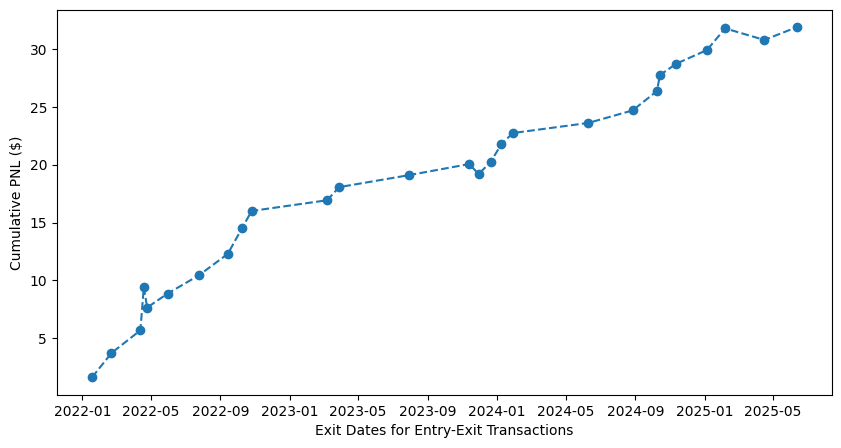

In [92]:
import matplotlib.pyplot as plt
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.plot(date_objects, pnl,marker='o', linestyle='dashed')
plt.xlabel('Exit Dates for Entry-Exit Transactions')
plt.ylabel('Cumulative PNL ($)')